In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['xtick.labelsize'] =20
#mpl.rcParams['ytick.labelsize'] = 20
#mpl.rcParams['legend.fontsize'] = 20
#mpl.rcParams['figure.titlesize'] = 20
import pymc3 as pm
from astropy.coordinates import Angle
import astropy.table as astrotable

splat.initializeStandards(all=True)
from scipy.interpolate import griddata, interpn
import splat.empirical as spe

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
%matplotlib inline

In [3]:
PS1_DEPTHS={ 'R':23.2, 'I':23.1, 'Z':22.3, 'Y':21.4}
SDSS_DEPTHS={'R':22.2, 'I':21.3, 'Z':20.5}
VISTA_DEPTHS={'J':19.5, 'H':18.6, 'KS':17.9}

In [4]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [5]:
#DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [6]:
#t1    = astrotable.Table.read(DATA_FOLDER+'Stripe_Defs6_ctheissen.fit') # open an FITS file
#t2    = astrotable.Table.read(DATA_FOLDER+'FieldNums_ctheissen.fit') # open an FITS file
#t3    = astrotable.join(t1, t2, keys='fieldid').to_pandas()

In [7]:
import glob

In [8]:
from astropy.io.votable import parse_single_table

In [9]:
#forget about sdss use
ffolder='/users/caganze/research/popsims/data/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [10]:
#dfl_conct.DEJ2000_VHS

In [11]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)


In [12]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [13]:
sdsscoord=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [14]:
a=Angle(sdsscoord.ra.to(u.radian))
b=Angle(sdsscoord.dec.to(u.radian))
a.wrap_at('180d', inplace=True)
b.wrap_at('180d', inplace=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


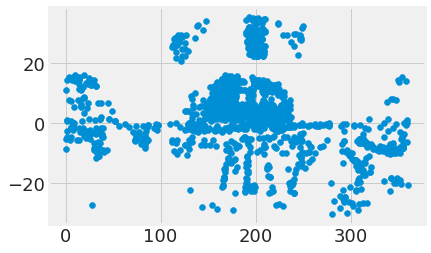

In [15]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [16]:
def interpolated(ra, dec, interpolators):
    #Ra dec must in degrees wrapped at 180 degree
    interpoints=np.array([interpolators[0], interpolators[1] ]).T
    return griddata(interpoints, interpolators[-1] , (ra, dec), \
                    method='cubic', fill_value=-1.)
def interpolated_broken(ra, dec,interpolators):
    interpoints=np.array([interpolators[0], interpolators[1] ])
    return  interpn(list(zip(interpoints)), interpolators[-1] , (ra, dec),\
                     fill_value=-1.,  bounds_error=False) 

In [17]:
from popsims.widefields import  WideField, create_mixed_population,\
transform_tocylindrical

In [18]:
#field= WideField(footprinttype='uniform')
#field.footprint=SDSS
#trace=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=1000)

In [19]:
thin_dist_list=[]
thick_dist_list=[]
halo_dist_list=[]
discr_ls=[]
discr_bs=[]

for i in tqdm(np.arange(1000)):
    c=sdsscoord[np.random.choice(len(sdsscoord))]
    narro_field=popsims.Pointing(coord=c)
    halo_field=popsims.Pointing(coord=c, density='spheroid')

    narro_field.mag_limits=dict(zip(['VISTA_{}'.format(k) for k in VISTA_DEPTHS.keys()],\
             [(0, VISTA_DEPTHS[k]) for k in VISTA_DEPTHS.keys()]))
    thin_dist_list +=list(narro_field.draw_distances(0.1, 1000,350,  nsample=1e3))
    thick_dist_list +=list(narro_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    halo_dist_list +=list(halo_field.draw_distances(0.1, 1000,900,  nsample=1e3))
    discr_ls += [c.galactic.l.value]
    discr_bs += [c.galactic.b.value]

In [20]:
def dra_distances_properly(df, distance_limits):
    df
    pass

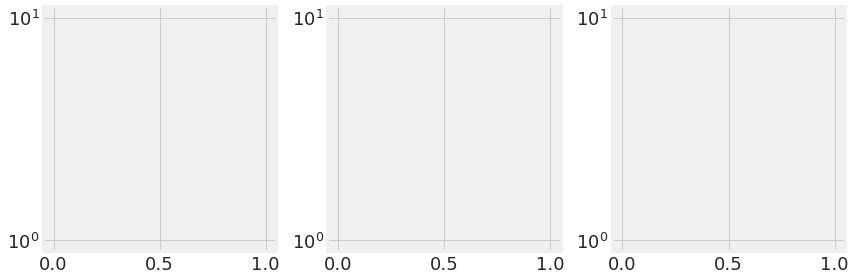

In [21]:
 fig, ax=plt.subplots(figsize=(12, 4), ncols=3)
h=ax[0].hist(  thin_dist_list, bins='auto',\
             log=True, histtype='step', lw=2)
h=ax[1].hist(  thick_dist_list, bins='auto',\
             log=True, histtype='step', lw=2)
h=ax[2].hist(  halo_dist_list, bins='auto',\
             log=True, histtype='step', lw=2)
plt.tight_layout()

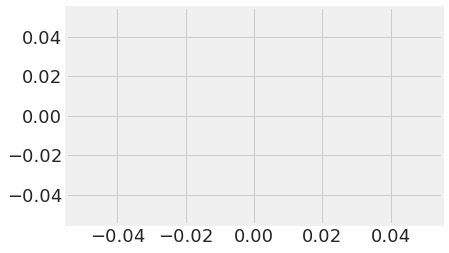

In [22]:
fig, ax=plt.subplots()
ax.scatter(discr_ls, discr_bs, s=10)

In [23]:
#np.save('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy',\
#        {'thind':thin_dist_list ,\
#         'thickd':thick_dist_list ,\
#         'halod': halo_dist_list,\
#         'l': discr_ls ,\
#         'b': discr_bs}, allow_pickle=True)

In [24]:
grid=np.arange(14, 40)

In [25]:
dictionary=np.load('/volumes/LaCie/popsimsdata/lodieupaper_distances.npy', allow_pickle=True)
dist_dictionary=dictionary.flatten()[0]
thin_dist_list= dist_dictionary['thind']
thick_dist_list= dist_dictionary['thickd']
halo_dist_list= dist_dictionary['halod']
discr_ls = dist_dictionary['l']
discr_bs = dist_dictionary['b']

In [26]:
max_distances={}
for g in grid:
    max_distances[g]=popsims.get_distance(popsims.POLYNOMIALS['VISTA_J'][0](g), 21.4)

In [27]:
def resample_distance(df, dmax_dict, population ):
    df['d']=np.nan
    if population=='thin_disk':
        ds=np.array(thin_dist_list)
    if population=='thick_disk':
        ds=np.array(thick_dist_list)
    if population=='halo':
        ds=np.array(halo_dist_list)
    ds=np.array(ds)
    df['spt_r']=np.round(df.spt)
    
    dx= ds[ds< dmax_dict[float(df.spt_r.iloc[0])] ]
    df['d']= np.random.choice(dx, len(df))
    return df
def sample_distance_properly(df, dmax_dict, population='thin_disk'):
    df['spt_r']=np.round(df.spt)
    groups=[]
    for g in tqdm( df.groupby('spt_r')):
        groups.append(resample_distance(g[1], dmax_dict, population))
    return pd.concat(groups)
                

In [28]:
df=popsims.make_systems(model='burrows1997', bfraction=0.2,\
                            mass_age_range=[0.01, 0.15, 0., 8.0], \
                                nsample=1e4,
                                recompute=False)


In [29]:
#max_distances

In [30]:
#sample_distance_properly(df,max_distances, population='thin_disk')

In [31]:
def get_uvw(age, kind='thin_disk',z=None):
    #velocity paremeters
    #returns simple gaussians from velocity dispersions
    
    v10 = 41.899
    tau1 = 0.001
    beta = 0.307

    v10_v = 28.823
    tau_v = 0.715
    beta_v = 0.430

    v10_w = 23.381
    tau_w = 0.001
    beta_w = 0.445

    k = 74.
    sigma_u = v10*((age+tau1)/(10.+tau1))**beta
    sigma_v =  v10_v*((age+tau_v)/(10.+tau_v))**beta_v
    sigma_w =  v10_w*((age+tau_w)/(10.+tau_w))**beta_w

    voff = -1.*(sigma_v**2)/k
    
    us=np.random.normal(loc=0, scale=sigma_u, size=len(age))
    vs =np.random.normal(loc=voff, scale=sigma_v, size=len(age))
    ws =np.random.normal(loc=0.0, scale=sigma_w, size=len(age))
    
    if kind=='halo':
        us=np.zeros(len(age))
        vs=np.zeros(len(age))
        ws=np.zeros(len(age))
        
        #0-4 kpc
        bools0=np.logical_and(np.abs(z) >=0, np.abs(z)<=4000)
        bools1=np.logical_and(np.abs(z) >4000, np.abs(z)>=8000)
        bools2=np.abs(z)>8000
        
        us[bools0]=np.random.normal(loc=-52, scale=242, size=len(z[bools0]))
        vs[bools0]=np.random.normal(loc=-242, scale=103, size=len(z[bools0]))
        ws[bools0]=np.random.normal(loc=0, scale=270, size=len(z[bools0]))
        
        us[bools1]=np.random.normal(loc=-12+270, scale=131+270, size=len(z[bools1]))
        vs[bools1]=np.random.normal(loc=-282+270, scale=-111+270, size=len(z[bools1]))
        ws[bools1]=np.random.normal(loc=-37+270, scale=85+270, size=len(z[bools1]))
        
        us[bools2]=np.random.normal(loc=-1+270, scale=172+270, size=len(z[bools2]))
        vs[bools2]=np.random.normal(loc=-328+270, scale=-119+270, size=len(z[bools2]))
        ws[bools2]=np.random.normal(loc=-32+270, scale=106+270, size=len(z[bools2]))

    if kind=='thick_disk':
        #use Bensby et al
        v_assym=46
        uvw_lsr=[0, 0, 0]
        us=np.random.normal(loc=uvw_lsr[0], scale=67,size=len(age))
        vs=np.random.normal(loc=uvw_lsr[1]-v_assym, scale=38,size=len(age))
        ws=np.random.normal(loc=uvw_lsr[-1], scale=35,size=len(age))
    
    return us, vs, ws



def create_pop(bfraction=None,\
                     model=None,  nsample=None,
                     dmax=None, l=None, b=None, \
               absmag_keys=['WFIRST_WFIJ'], 
              population='thin_disk', dmax_dict=None):
   
    if population =='thin_disk':
        df=popsims.make_systems(model=model, bfraction=bfraction,\
                            mass_age_range=[0.01, 0.15, 0., 8.0], \
                                nsample=nsample,
                                recompute=True)
        df=df[df.spt.between(grid[0], grid[-1])]
        #df=df.sample(n=len(ds))

        #assign distances
        df=sample_distance_properly(df, dmax_dict, population=population)
        df['l']=np.random.choice(l, len(df))
        df['b']=np.random.choice(b, len(df))
        r, z=transform_tocylindrical(df.l.values, df.b.values, df.d.values)
        df['r']=r
        df['z']=z
        us, vs, ws=get_uvw(df.age, kind=population)
    
        df['U']=us
        df['V']=vs
        df['W']=ws
        
    if population =='thick_disk':
        df=popsims.make_systems(model=model, bfraction=bfraction,\
                                 nsample=nsample,
                            mass_age_range=[0.01, 0.15, 8., 13.0], recompute=True)
        df=df[df.spt.between(grid[0], grid[-1])]
        #df=df.sample(n=len(ds))
        #assign distances
          #assign distances
        df=sample_distance_properly(df, dmax_dict, population=population)
        df['l']=np.random.choice(l, len(df))
        df['b']=np.random.choice(b, len(df))
        r, z=transform_tocylindrical(df.l.values, df.b.values, df.d.values)
        df['r']=r
        df['z']=z
        us, vs, ws=get_uvw(df.age, kind=population)
    
        df['U']=us
        df['V']=vs
        df['W']=ws
        
    if population =='halo':
        df=popsims.make_systems(model=model, bfraction=bfraction,\
                                 nsample=nsample,
                            mass_age_range=[0.01, 0.15, 10., 13.0], recompute=True)
        df=df[df.spt.between(grid[0], grid[-1])]
        #df=df.sample(n=len(ds))
        
        #assign distances
        df=sample_distance_properly(df, dmax_dict, population=population)
        df['l']=np.random.choice(l, len(df))
        df['b']=np.random.choice(b, len(df))
        r, z=transform_tocylindrical(df.l.values, df.b.values, df.d.values)
        df['r']=r
        df['z']=z
        us, vs, ws=get_uvw(df.age, z= df.z, kind='halo')
        df['U']=us
        df['V']=vs
        df['W']=ws

    dff=popsims.get_magnitudes(df.spt, df.d, keys=absmag_keys).join(df)
    return dff

In [32]:
popsims.DATA_FOLDER

'/volumes/LaCie/wispsdata/db/'

In [33]:
len(thin_dist_list)

1000000

In [34]:
#d0=np.random.choice(thin_dist_list, int(1e6))
#d1=np.random.choice(thick_dist_list, int(1e6))
#d2=np.random.choice(halo_dist_list, int(1e6))
#l=np.random.choice, int(1e6))
#b=np.random.choice(discr_bs, int(1e6))

#r1, z1=transform_tocylindrical(l, b, d1)
#r2, z2=transform_tocylindrical(l, b, d2)

In [35]:
mag_keys0=['VISTA_Z', 'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS', 'UKIDSS_Z', \
'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K']

In [36]:
#max_distances

In [37]:
tqdm.pandas()
df_thin=df=create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=1e6, dmax_dict=max_distances)

100%|██████████| 26/26 [00:02<00:00,  8.80it/s]


In [38]:
df_thick=df=create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=1e6, dmax_dict=max_distances,
                         population='thick_disk')

100%|██████████| 26/26 [00:02<00:00, 12.19it/s]


In [39]:

df_halo=df=create_pop(bfraction=0.2,\
                         model='burrows1997',\
                             l=discr_ls, b=discr_bs,\
                           absmag_keys=mag_keys0, \
                      nsample=1e6, dmax_dict=max_distances,
                         population='halo')


100%|██████████| 26/26 [00:02<00:00, 12.14it/s]


[(-400.0, 400.0),
 (0.0, 400.0),
 Text(0.5, 0, 'V (km/s)'),
 Text(0, 0.5, ' $(U^2+ W^2)^{0.5}$(km/s)')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


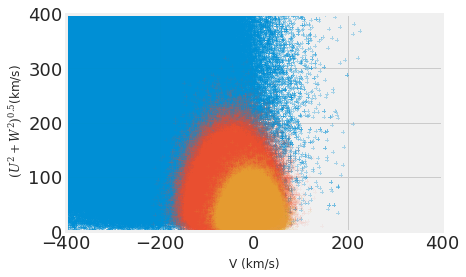

In [40]:
fig, ax=plt.subplots()
ax.scatter(df_halo.V.values, (df_halo.U.values**2+ df_halo.W.values**2  )**0.5, \
           alpha=0.3, s=1,  marker='+')
ax.scatter(df_thick.V.values, (df_thick.U.values**2+ df_thick.W.values**2  )**0.5, \
           s=1, alpha=0.05, marker='+')
ax.scatter(df_thin.V.values, (df_thin.U.values**2+ df_thin.W.values**2  )**0.5,\
           alpha=0.05, s=1, marker='+')
ax.minorticks_on()
ax.set(xlim=[-400, 400], ylim=[0, 400],xlabel='V (km/s)', \
       ylabel=r' $(U^2+ W^2)^{0.5}$(km/s)')

In [41]:
#traceclose=field.sample_points(nsample=1e5, Hthin=350, dmin=1, dmax=100)

In [42]:
df_thin['population']='thin_disk'
df_thick['population']='thick_disk' 
df_halo['population']='halo'

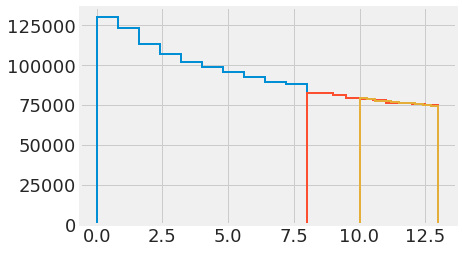

In [43]:
h=plt.hist(df_thin.age, histtype='step', lw=2, log=False)
h=plt.hist(df_thick.age, histtype='step', lw=2, log=False)
h=plt.hist(df_halo.age, histtype='step', lw=2, log=False)

In [44]:
len(df_thin)

1041442

In [45]:
nsample=1e6
df=pd.concat([df_thin.sample(n=int(nsample*0.875)), \
              df_thick.sample(n=int(nsample*0.12)), \
              df_halo.sample(n=int(nsample*0.005))])

In [46]:
#Add some of these to my 
key_pairs={'best2018': ['PANSTARRS_G', 'PANSTARRS_R', \
                         'PANSTARRS_I', 'PANSTARRS_Z', 'PANSTARRS_Y'],
           'dupuy2012': ['2MASS_J', '2MASS_H', '2MASS_K', 'MKO_J', 'MKO_H']
          }

subd_key_pairs={'zhang2013':['SDSS_R', 'SDSS_I', 'SDSS_Z',\
                '2MASS_J', '2MASS_H', '2MASS_KS'] }

In [47]:
ABS_MAG_FILE='/users/caganze/research/popsims/data/polynomial_relations.pkl'

In [48]:
H20_POL=(pd.read_pickle(ABS_MAG_FILE)['colors']['hawley2002'])

In [49]:
for ref in key_pairs.keys():
    print (ref)
    for k in key_pairs[ref]:
        absmags, errs=spe.typeToMag(df.spt.values, \
                                             filt=k, ref=ref)
        df['abs_{}'.format(k)]=np.random.normal(absmags, errs)

        df[k]=df['abs_{}'.format(k)]+5*np.log10(df.d/10.0)

#add SDSS mags from colors-MK0 J RELATION
df['SDSS_I']=np.random.normal(H20_POL['i-J']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['i-J']['unc']))\
                              +df['2MASS_J'].values
df['SDSS_Z']=np.random.normal(H20_POL['z-J']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['z-J']['unc']))\
                              +df['2MASS_J'].values
df['SDSS_R']=np.random.normal(H20_POL['r-i']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['r-i']['unc']))\
                              +df['SDSS_I'].values

df['abs_SDSS_I']=np.random.normal(H20_POL['i-J']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['i-J']['unc']))\
                              +df['abs_2MASS_J'].values
df['abs_SDSS_Z']=np.random.normal(H20_POL['z-J']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['z-J']['unc']))\
                              +df['abs_2MASS_J'].values
df['abs_SDSS_R']=np.random.normal(H20_POL['r-i']['pol'](df.spt.values),\
                              np.nanmedian(H20_POL['r-i']['unc']))\
                              +df['abs_SDSS_I'].values

#Add a subdarf SDSS relation from zhang
#for k in subd_key_pairs['zhang2013']:
#    bools=(df['population']=='halo').values
#    absmags, errs=spe.typeToMag(df.spt.values[bools], \
#                                         filt=k, ref='zhang2013')
#    df['abs_{}'.format(k)].loc[bools]=np.random.normal(absmags, errs)
#    df[k].loc[bools]=(df['abs_{}'.format(k)]+5*np.log10(df.d/10.0))[bools]

best2018
dupuy2012


In [50]:
len(df['SDSS_I'].dropna()), len(df['2MASS_J'].dropna())

(426628, 766795)

In [51]:
#df

In [52]:
def interpolate_sdss(ra, dec):
    interpolators=[a.to(u.degree).value, b.to(u.degree).value, np.ones_like(a)]
    return interpolated(ra, dec, interpolators )

In [53]:
def apply_sdss_selection(df):
    entiregalaxy=SkyCoord(l=df.l*u.radian,\
                     b=df.b*u.radian, frame='galactic')
    
    gridra=Angle(entiregalaxy.icrs.ra.to(u.radian))
    gridra.wrap_at('180d', inplace=True)
    griddec=Angle(entiregalaxy.icrs.dec.to(u.radian))
    griddec.wrap_at('180d', inplace=True)

    selectionfunction=interpolate_sdss(gridra.to(u.degree).value, \
                                                  griddec.to(u.degree).value)
    df['SDSS_selection']= selectionfunction
    df['ra']=gridra
    df['dec']=griddec
    return df
    

In [54]:
def get_proper_motion(ra, dec, d, u, v, w):
    
    motions=popsims.tools.compute_pm_from_uvw(ra, dec,d, u, v, w,\
                               correct_lsr=False)
    return pd.Series({'RV':  motions[0] ,\
                      'mu_alpha': motions[1],\
                      'mu_delta': motions[2],
                      'Vtan': motions[-1]})

In [55]:

#df['ra']=dfn_coord.icrs.ra
#df['dec']=dfn_coord.icrs.dec

In [56]:

#bools=df.SDSS_selection==1.
other_bools=[]
#other_bools.append(bools)
for k in PS1_DEPTHS.keys():
    other_bools.append((df['PANSTARRS_{}'.format(k)]>PS1_DEPTHS[k]).values)
for k in SDSS_DEPTHS.keys():
    other_bools.append((df['SDSS_{}'.format(k)]>SDSS_DEPTHS[k]).values)
for k in VISTA_DEPTHS.keys():
    other_bools.append((df['VISTA_{}'.format(k)]>VISTA_DEPTHS[k]).values)
tot_bools=~np.logical_or.reduce(other_bools)


In [57]:
df['spt_r']=df.spt.apply(np.round)

In [58]:
dfn=df[tot_bools]

In [59]:
len(dfn)

22810

In [60]:
cmap = plt.get_cmap('cividis')
colors = cmap(np.linspace(0, 1, len(dfn.groupby('spt_r'))))

14.0 990.8228099003798
15.0 990.8228099003798
16.0 990.8228099003798
17.0 237.34242500238662
18.0 153.88177500383463
19.0 98.85417021919574
20.0 86.88382635251185
21.0 71.59041085964888
22.0 61.771875973384944
23.0 58.447611316336314
24.0 30.372635797033116
25.0 22.612800663372774
26.0 12.767507043192657
27.0 10.617591834830002
28.0 9.505565920101196
30.0 9.505565920101196
31.0 1.9466563433422623
32.0 9.161402457138516
33.0 9.077326525210228
34.0 6.9477125484602364
35.0 6.9477125484602364
36.0 35.85539857459817
37.0 24.796728925021576
38.0 23.462288481422625
39.0 18.124175473742376


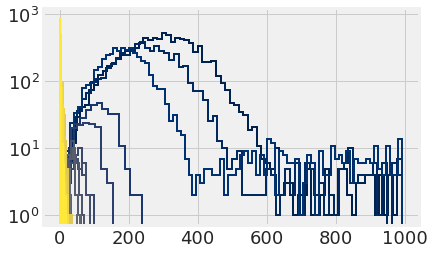

In [61]:
fig, ax=plt.subplots()
for g, co in zip(dfn.groupby('spt_r'), colors):
    print (g[0], np.nanmax(g[1].d.values))
    h=plt.hist(g[1].d.values, bins='auto', \
               histtype='step', lw=2, log=True, \
    
               label=g[1], color=co)
    

[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Spectral Type')]

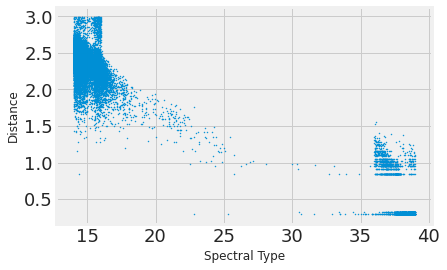

In [62]:
fig, ax=plt.subplots()
h=plt.scatter(dfn.spt, np.log10(dfn.d), s=1, alpha=0.9)
ax.set(ylabel='Distance', xlabel='Spectral Type')

[Text(0.5, 0, 'Distance')]

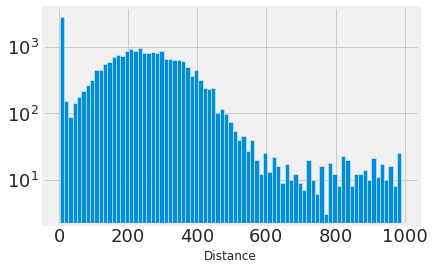

In [63]:
fig, ax=plt.subplots()
h=plt.hist(dfn.d, bins='auto', log=True)
ax.set(xlabel='Distance')

In [64]:
dfn_coord=SkyCoord(l=dfn.l*u.degree, b=dfn.b*u.degree, frame='galactic')

In [65]:
dfn['ra']=dfn_coord.icrs.ra.to(u.degree)
dfn['dec']=dfn_coord.icrs.dec.to(u.degree)

In [66]:
tqdm.pandas()
motion_df=dfn[['ra', 'dec', 'd', 'U', 'V', \
       'W' ]].progress_apply(lambda x: get_proper_motion(*x), axis=1)

100%|██████████| 22810/22810 [02:12<00:00, 172.46it/s]


In [67]:
dfj=dfn.join(motion_df)

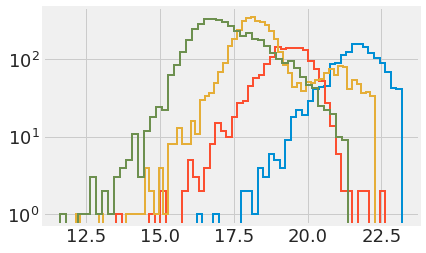

In [68]:
fig, ax=plt.subplots()
for k in PS1_DEPTHS.keys():
    #h=plt.hist(df['PANSTARRS_{}'.format(k)], bins='auto', histtype='step',\
    #           lw=2, log=True, linestyle='--')
    h=plt.hist(dfn['PANSTARRS_{}'.format(k)].values, bins='auto',\
               histtype='step', lw=2, log=True)

In [69]:
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    dfj['redH_{}'.format(k)]=dfj['abs_{}'.format(k)]+\
     5*np.log10((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5)+5

[Text(0.5, 0, 'Reduced Proper Motion')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


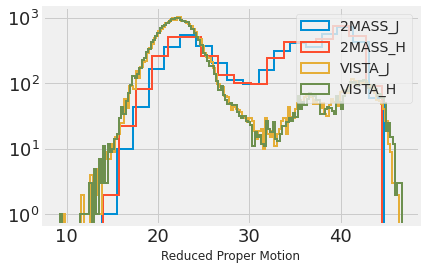

In [70]:
fig, ax=plt.subplots()
for k in [ '2MASS_J', '2MASS_H', 'VISTA_J', 'VISTA_H']:
    vals=dfj['redH_{}'.format(k)].values
    h=plt.hist(vals,\
               bins='auto', histtype='step', lw=2, 
               log=True, label=k)
plt.legend(fontsize=14)
ax.set(xlabel='Reduced Proper Motion')

[None,
 None,
 Text(0.5, 0, 'Proper motion (mas/yr)'),
 Text(0, 0.5, 'Distance (pc)'),
 (0.1, 1000.0),
 (10, 1000.0)]

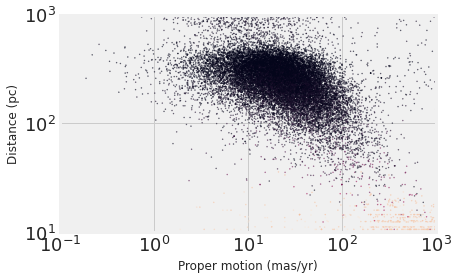

In [71]:
fig, ax=plt.subplots()

h=ax.scatter((dfj.mu_alpha**2+ dfj.mu_delta**2)**0.5, dfj.d,  c=dfj.spt, s=1, alpha=0.5)
ax.set(xscale='log', yscale='log', xlabel='Proper motion (mas/yr)', \
       ylabel='Distance (pc)', xlim=[1e-1, 1e3], ylim=[10, 1e3])

[Text(0.5, 0, 'SDSS I-J'), Text(0, 0.5, 'H$_J$')]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


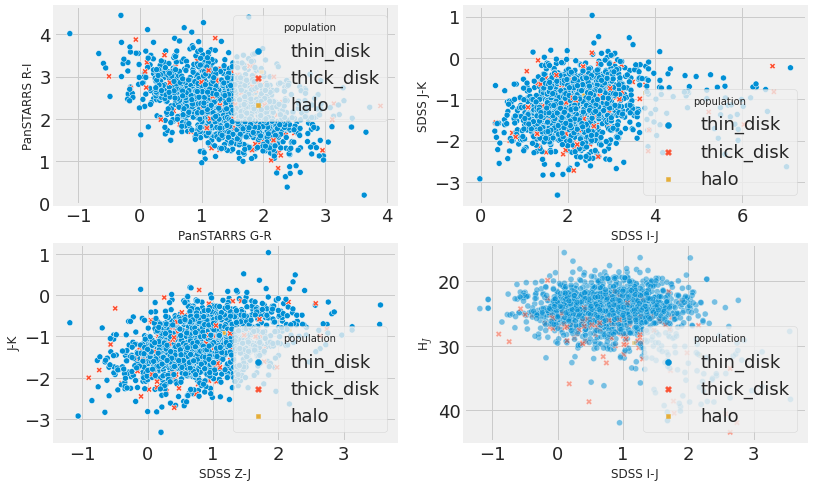

In [72]:
### color-color plots
fig, ax=plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

c=sns.scatterplot((dfj.PANSTARRS_G-dfj.PANSTARRS_R),\
             (dfj.PANSTARRS_R-dfj.PANSTARRS_I),
          hue='population', \
               ax=ax[0][0], data=dfj, style='population', )

c=sns.scatterplot((dfj.SDSS_I-dfj['VISTA_J']),\
              (dfj['2MASS_J']-dfj['VISTA_KS']),
                   hue='population', \
               ax=ax[0][1], data=dfj, style='population', )

c=sns.scatterplot((dfj.SDSS_Z-dfj['VISTA_J']),\
              (dfj['2MASS_J']-dfj['VISTA_KS']),
          hue='population', \
               ax=ax[1][0], data=dfj, style='population')



#c=ax[1][1].scatter((dfj.SDSS_Z-dfj['VISTA_J']),\
#                   dfj['redH_{}'.format('VISTA_J')],
#           s=20., alpha=0.5)
sns.scatterplot((dfj.SDSS_Z-dfj['VISTA_J']),\
                   dfj['redH_{}'.format('VISTA_J')], hue='population', \
               ax=ax[1][1], data=dfj, style='population', alpha=0.5 )

ax[1][1].invert_yaxis()

ax[0][0].set(xlabel='PanSTARRS G-R',\
      Ylabel='PanSTARRS R-I',)

ax[0][1].set(xlabel='SDSS I-J',\
      Ylabel='SDSS J-K',)

ax[1][0].set(xlabel='SDSS Z-J',\
      Ylabel='J-K',)

ax[1][1].set(xlabel='SDSS I-J',\
      Ylabel=r'H$_J$',)


In [73]:
df['selection_function']=tot_bools

In [74]:
def get_ncounts(binby='spt', grid=np.arange(15, 40),
               sd=False):
    scale=[df.scale.mean(), df.scale_unc.mean(),df.scale_times_model.mean()]
    NSIM=dict(zip(grid, np.zeros((len(grid), 2))))
    df['r_{}'.format(binby)]=df[binby].apply(np.round)

    for g in tqdm(df.groupby('r_{}'.format(binby))):
        sn= len(df[np.logical_and(df.temperature>=450, df.temperature<=2100)])
        n0=scale[-1]/scale[0]
        #print (n0)
        scln=np.array([scale[0]*n0/sn,\
                       (scale[1]*scale[-1])/(sn*scale[0])])
        
        if sd:
            b0=np.logical_and(df.temperature>=450, df.temperature<=2100)
            b1=df.population=='halo'
            nhalo=len(df[np.logical_and(b0, b1)])/sn
            scln=scln*nhalo

        
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].selection_function)*scln
    df.drop('r_{}'.format(binby), axis=1)
    return pd.DataFrame(NSIM).T.rename(columns={0: 'N', 1: 'Nunc'})

In [75]:

counts=get_ncounts(grid=grid)
sdcounts=get_ncounts(grid=grid, sd=True)

100%|██████████| 26/26 [00:12<00:00,  2.12it/s]


In [76]:
import scipy.integrate as integrate
from popsims.widefields import galactic_density

In [77]:
def compute_volume(spt, l, b):
    dmin=0
    dmax=max_distances[spt]
    
    if np.isnan(dmax):
        return np.nan
    else:
        ds=np.linspace(dmin, dmax, 1000)

        rd=np.sqrt( (ds * np.cos( b ) )**2 + popsims.Rsun * (popsims.Rsun - 2 * ds * np.cos( b ) * np.cos( l ) ) )
        zd=popsims.Zsun+ ds * np.sin( b - np.arctan( popsims.Zsun / popsims.Rsun) )
        rh=galactic_density(rd, zd, 350)
        return integrate.trapz(rh*(ds**2), x=ds)


In [78]:
#tqdm.pandas()
#t3['unique_field_id']=t3.progress_apply(lambda x: str(x.run)+','\
#                                        +str(x.fieldid)+','\
#                                        +str(x.camcol)+',', axis=1)

In [79]:
#unique_fields=(sdsscoord[t3.drop_duplicates('unique_field_id').index]).galactic

In [80]:
#quickest method simulate one field and multiply by the number of unique field areas

In [81]:
volumes={}
for k in grid:
    vs=0.0
    for f in tqdm(dfn_coord):
        l=f.l.radian
        b=f.b.radian
        vs +=compute_volume(k, l, b)
    volumes[k]=vs

100%|██████████| 22810/22810 [00:33<00:00, 684.77it/s] 


In [82]:
#save this, takes too much time to do
#volumes

In [83]:
#easiest ay is to compute volumes for every field and then
#second easiest thing, simulate an entire sky and do 2d-interpolation over sdss area

In [84]:
counts['volume']=pd.Series(volumes).T/len(dfn_coord)
sdcounts['volume']=pd.Series(volumes).T/len(dfn_coord)

In [85]:
len(dfn_coord)

22810

In [86]:
area=5350*(u.degree**2).to(u.radian**2)

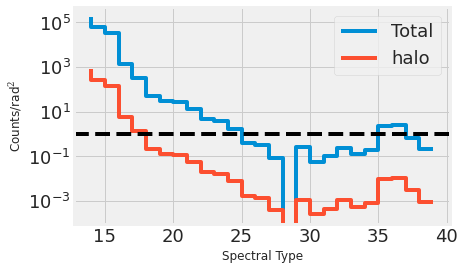

In [87]:
fig, ax=plt.subplots()

ax.step(counts.index, counts.N*(counts.volume)*area, label='Total')
ax.step(sdcounts.index, sdcounts.N*(counts.volume)*area,label='halo')
ax.set(yscale='log', xlabel='Spectral Type',  ylabel=r'Counts/rad$^2$' )
ax.axhline(1, linestyle='--', c='k')
#ax.axhline(100, linestyle='--', c='k')
plt.legend()

In [88]:
#